## IMPORTS

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
from glob import glob


sys.path.append('../../')
from utils import clustering_utils, bokeh_ui_utils, file_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
full_filtered_df = pd.read_csv('../../active_fastas/rna_seq.csv')
full_filtered_norm_df = full_filtered_df

num_genes = full_filtered_df.shape[0]
num_genes

24648

In [3]:
full_filtered_df.sample(10)

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
10535,TTHERM_00037640,1.206377,1.130671,1.196364,1.253423,1.330733,1.383833,1.434550,1.392457,1.298355
7482,TTHERM_00011040,-1.108369,-1.009744,-0.806990,-0.578517,-0.306267,-0.281165,-0.380353,-0.486032,-0.773063
3526,YF00004681.t1,-0.680838,-0.746319,-0.695427,-0.801934,-0.772595,-0.794390,-0.795861,-0.757395,-0.766721
18315,TTHERM_00449190,-0.871127,-0.455888,-0.154629,-0.089854,-0.033908,-0.086073,-0.509890,-0.656346,-0.631362
9748,TTHERM_01016180,-0.577234,-0.591822,-0.618131,-0.695155,-0.634515,-0.577889,-0.514484,-0.372145,-0.386702
7061,TTHERM_00678080,-0.383191,-0.677484,-0.760982,-0.817933,-0.594858,-0.548237,-0.385753,-0.285917,-0.527593
11782,TTHERM_01248940,-0.702532,-0.684585,-0.753809,-0.750147,-0.751654,-0.745933,-0.763696,-0.733004,-0.749331
8991,TTHERM_00557870,0.564372,0.499396,0.675862,0.925927,1.005579,1.129428,0.681341,0.321200,0.082858
4920,TTHERM_00471420,0.608729,0.794945,0.851147,1.008392,1.069637,1.128693,0.774344,0.381771,0.134002
5957,TTHERM_00675900,-0.591421,-0.591421,-0.591421,-0.591421,-0.591421,-0.591421,-0.591421,-0.591421,-0.591421


In [4]:
cycle_expression_conflict_df = full_filtered_df.loc[
    (full_filtered_df['000min'] > 0.9)
    &
    (full_filtered_df['210min'] < 0.1)
    &
    (full_filtered_df['240min'] < 0.1)
]

In [5]:
cycle_expression_conflict_df

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
210,TTHERM_00155510,0.959926,0.771133,0.610407,0.682444,0.484447,0.371332,0.140121,-0.243053,-0.661809
437,TTHERM_00305480,0.982791,0.781776,0.633657,0.449937,0.435884,0.663268,0.378840,0.082542,-0.042972
581,YF00000753.t1,1.262076,0.689501,0.373788,0.462162,0.441707,0.698280,0.220730,0.074315,0.018294
771,YF00001001.t1,1.440275,1.146811,0.931641,0.883872,0.710736,0.966358,0.470951,0.029971,-0.322773
940,TTHERM_00535610,0.949552,-0.363664,-0.580546,-0.646016,-0.596335,-0.576639,-0.629856,-0.692737,-0.544234
1148,TTHERM_00530810,1.025750,0.694984,0.636442,0.593156,0.481952,0.669100,0.288184,0.065160,-0.015313
1613,TTHERM_00732750,0.977730,0.647368,0.710656,0.606200,0.624976,0.723098,0.402078,0.087460,0.018010
1788,TTHERM_000420229,1.023593,0.634348,0.520219,0.425763,0.475176,0.639282,0.365084,0.096997,0.024046
3376,TTHERM_000509089,0.959481,0.431529,0.402436,0.368891,0.231623,0.214494,-0.270822,-0.548804,-0.993229
4122,TTHERM_00145380,0.907184,0.219030,0.091439,0.012045,0.011612,0.088883,-0.166122,-0.210819,-0.275350


In [6]:
cycle_expression_conflict_df.to_csv('./cycle_expression_conflict.csv')

### LEIDEN CLUSTERING

In [7]:
phases = 'rna_seq'

In [8]:
metric = 'manhattan'
# metric='minkowski_3.0'

# resolution_param=0.050
resolution_param=0.005

n_neighbors = 3

dataset = 'rna_seq'

In [9]:
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_df, 
    dataset,
    metric=metric, 
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [10]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./rna_seq_label_df_round_1.csv', index=False)

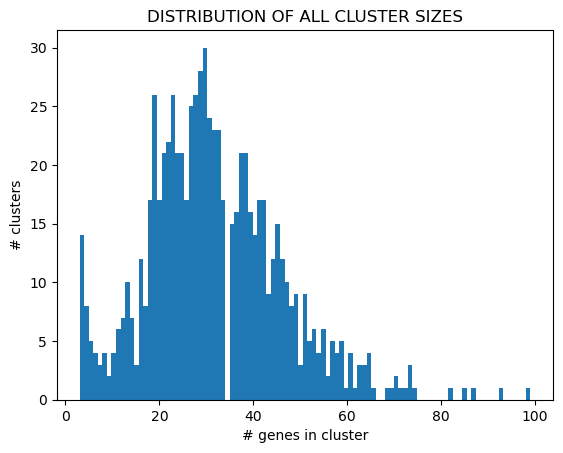

In [11]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

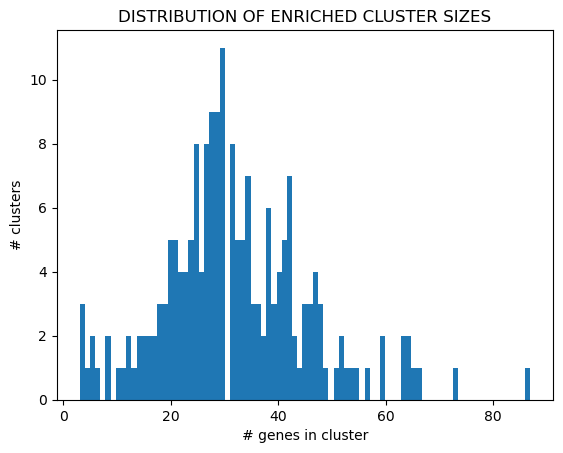

In [12]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [13]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.04577224806614421
                  modularity: 0.8297365665668015
                   nclusters: 774
           mean_cluster_size: 31.844961240310077
         median_cluster_size: 30.0
             sd_cluster_size: 14.570571175432438
          nenriched_clusters: 192
  mean_enriched_cluster_size: 31.921875
median_enriched_cluster_size: 30.0
    sd_enriched_cluster_size: 13.746557926175859
     nenriched_cluster_genes: 6129
                    datetime: 2024-05-06 21:51:05.713735


In [14]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [15]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [16]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [17]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [18]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [19]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [20]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [21]:
import os

embedding_metric = 'manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['rna_seq', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, 'rna_seq', color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, embedding_metric=embedding_metric, n_neighbors=n_neighbors)

/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:495: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard322_rna_seq_umap_manhattan_3nn_0.005rp.html


In [22]:
# (HH2A.1, HH2A.2, HH2B.1, HH2B.2, HH3, HH4.1, and HH4.2)
HHs = [
"TTHERM_00189170", "TTHERM_00143660", "TTHERM_00633360", "THERM_00283180", 
]

# (Figure 3A; CPD1, CPD2, and CPG3 and SMC2 and SMC4).
CPD_CPG_SMC = [
"TTHERM_00486070", "TTHERM_00392760", "TTHERM_00919690", "TTHERM_00812950", "TTHERM_0044640", 
]

# cyclin D family members, CYC4, CYC13, and CYC25
cyclin_D_family_members = [
"TTHERM_01043080", "TTHERM_01128530", "TTHERM_00717540",
]

# all cyclins
cyclins = [
'TTHERM_00196590',
'TTHERM_00433390',
'TTHERM_00526250',
'TTHERM_00962160',
'TTHERM_01128530',
'TTHERM_00189230',
'TTHERM_00425970',
'TTHERM_00780580',
'TTHERM_00693080',
'TTHERM_00827080',
'TTHERM_00698650',
'TTHERM_00079530',
'TTHERM_00624450',
'TTHERM_00784350',
'TTHERM_00933270',
'TTHERM_00732460',
'TTHERM_00842480',
'TTHERM_00717540',
'TTHERM_00066840',
'TTHERM_000576939',
'TTHERM_00082190',
'TTHERM_00649450',
'TTHERM_00180970',
'TTHERM_00726380',
'TTHERM_00013060',
'TTHERM_00049420',
'TTHERM_00294860',
'TTHERM_00535270',
'TTHERM_01043080',
'TTHERM_00192000',
'TTHERM_00194440',
'TTHERM_00293270',
'TTHERM_00332170',
'TTHERM_00940290',
]

cyc_subset = [
'TTHERM_00196590', # CYC1 
'TTHERM_00425970', # CYC15
'TTHERM_00624450', # CYC20
'TTHERM_00842480', # CYC24
'TTHERM_00194440', # CYC6
'TTHERM_00332170', # CYC8
]

all_cdks = [
'TTHERM_00411810', #	CDK1
'TTHERM_00318700', #	CDK10
'TTHERM_00576780', #	CDK11
'TTHERM_00267860', #	CDK13
'TTHERM_00394590', #	CDK14
'TTHERM_01035490', #	CDK15
'TTHERM_00624260', #	CDK16
'TTHERM_00066860', #	CDK17
'TTHERM_00784290', #	CDK18
'TTHERM_00339880', #	CDK19
'TTHERM_01347900', #	CDK20
'TTHERM_000837979', #	CDK21
'TTHERM_000937671', #	CDK22
'TTHERM_00011670', #	CDK3
'TTHERM_00286770', #	CDK4
'TTHERM_01080600', #	CDK5
'TTHERM_00837980', #	CDK6
'TTHERM_00133750', #	CDK7
'TTHERM_00717780', #	CDK8
'TTHERM_00185770', #	CDK9
'TTHERM_00483640', #	TCDK3
]

nucleic_acid_metabolic_process = [
'TTHERM_00046490',
'TTHERM_00535470',
'TTHERM_00312260',
'TTHERM_01079170',
'TTHERM_000378989',
'TTHERM_00825460',
'TTHERM_00298220',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00794250',
]

telomere_maintenance = [
'TTHERM_000378989',
'TTHERM_00433640',
'TTHERM_00112560',
'TTHERM_00561799',
]

# DECENT
mitotic_nuclear_division = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

mitotic_cell_cycle = [
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00118700',
'TTHERM_00079520',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00498210',
]

chromosome_organization = [
'TTHERM_00088010',
'TTHERM_00307700',
'TTHERM_00486070',
'TTHERM_00919690',
'TTHERM_00728870',
'TTHERM_00540340',
'TTHERM_00554600',
'TTHERM_01299730',
'TTHERM_00189170',
'TTHERM_00790790',
'TTHERM_00316500',
'TTHERM_00143660',
'TTHERM_00633360',
'TTHERM_00283180',
'TTHERM_00316410',
'TTHERM_00393260',
'TTHERM_00444760',
'TTHERM_00455130',
'TTHERM_000378989',
'TTHERM_00726370',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00787360',
'TTHERM_00112560',
'TTHERM_00561799',
]

DNA_repair = [
'TTHERM_00307700',
'TTHERM_00046490',
'TTHERM_00624870',
'TTHERM_000191179',
'TTHERM_00312260',
'TTHERM_00316410',
'TTHERM_00439320',
'TTHERM_01050440',
'TTHERM_01079170',
'TTHERM_01106120',
'TTHERM_00726470',
'TTHERM_00455309',
'TTHERM_00825460',
'TTHERM_00726370',
'TTHERM_00142290',
'TTHERM_00684490',
'TTHERM_00433640',
'TTHERM_00561799',
'TTHERM_00723610',
'TTHERM_00888060',
'TTHERM_00864890',
'TTHERM_00829440',
'TTHERM_00794250',
]

microtubule_cytoskeleton_organi = [
'TTHERM_00335970'
'TTHERM_00426160'
'TTHERM_01220340'
'TTHERM_00522990'
'TTHERM_00338260'
'TTHERM_000727749'
'TTHERM_000123789'
'TTHERM_000161298'
'TTHERM_00030040'
'TTHERM_000357129'
'TTHERM_00046500'
'TTHERM_000488189'
'TTHERM_000706399'
'TTHERM_00088040'
'TTHERM_00133700'
'TTHERM_00266668'
'TTHERM_00346790'
'TTHERM_00452020'
'TTHERM_00493000'
'TTHERM_00755750'
'TTHERM_00842510'
'TTHERM_00992710'
]

# all MCMs
all_MCMs = [
'TTHERM_00554270',
'TTHERM_00092850',
'TTHERM_00277550',
'TTHERM_00069420',
'TTHERM_00448570',
'TTHERM_00011740',
'TTHERM_01031060',
'TTHERM_00703910',
'TTHERM_01207610',
]

MCM_subset = ['YF00026324.1', 'YF00025215.1', 'YF00018584.1', 'YF00012156.1']
# YF00026324, YF00025215, YF00018584, YF00012156
# MCM5, MCM6, MCM3, MCM2

mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

histones = ['TTHERM_00146340', 'TTHERM_00446570', 'TTHERM_00498190', 'TTHERM_00189170', 'TTHERM_00189180', 'TTHERM_00016170', 'TTHERM_00016200', 'TTHERM_00790790', 'TTHERM_00316500', 'TTHERM_00143660', 'TTHERM_01079200', 'TTHERM_00633360', 'TTHERM_00283180', 'TTHERM_00354710', 'TTHERM_00474790', 'TTHERM_00852840', 'TTHERM_01194650']

In [23]:
gene_lists = {}
gene_lists = {
'HHs': HHs,
'CPD_CPG_SMC': CPD_CPG_SMC,
'cyclin_D_family_members': cyclin_D_family_members,
'cyclins': cyclins,
'cyc_subset': cyc_subset,
'all_cdks': all_cdks,
'nucleic_acid_metabolic_process': nucleic_acid_metabolic_process,
'telomere_maintenance': telomere_maintenance,
'mitotic_nuclear_division': mitotic_nuclear_division,
'mitotic_cell_cycle': mitotic_cell_cycle,
'chromosome_organization': chromosome_organization,
'DNA_repair': DNA_repair,
'microtubule_cytoskeleton_organi': microtubule_cytoskeleton_organi,
'all_MCMs': all_MCMs,
'MCM_subset': MCM_subset,
'mucocyst_cluster': mucocyst_cluster,
'histones' : histones,
}

In [24]:
xls_files = glob('../../new_raw_data/rna_seq_processed/xls_files/*.xls')
sorted(xls_files)

['../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s01.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s02.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s03.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s04.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s05.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s06.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s07.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s08.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s09.xls',
 '../../new_raw_data/rna_seq_processed/xls_files/mc-e22-08-0326-s10.xls']

In [25]:
for xls_file in xls_files:
    excel_file = pd.read_excel(xls_file, sheet_name=None)
    for sheet_name, df in excel_file.items():
        target_ids = []
        gene_cluster_assignments_mode_only = None

        first_column = list(df.iloc[:, 0].values)

        if sheet_name in gene_lists:
            name_num = 0
            new_sheet_name = sheet_name
            while new_sheet_name in gene_lists:
                name_num += 1
                new_sheet_name = f'{sheet_name}_{name_num}'
            print(f'WARNING: DUPLICATE GENE LIST NAME: \'{sheet_name}\'. RENAMING TO \'{new_sheet_name}\'.')
            sheet_name = new_sheet_name

        gene_lists[sheet_name] = first_column

In [26]:
fraction_threshold = 0.1

clustering_utils.multi_fraction_max_same_cluster_genes(gene_lists, leiden_label_df_round_1_arranged_sorted, fraction_threshold=fraction_threshold, print_mode=True)

GENE_LIST: HHs
TTHERM_00189170
TTHERM_00633360
THERM_00283180
UTILS:  1
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: CPD_CPG_SMC
TTHERM_00919690
TTHERM_0044640
UTILS:  3
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyclin_D_family_members
TTHERM_00717540
UTILS:  2
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyclins
TTHERM_00693080
TTHERM_00717540
TTHERM_00082190
TTHERM_00535270
UTILS:  30
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: cyc_subset
UTILS:  6
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: all_cdks
TTHERM_000937671
TTHERM_00837980
UTILS:  19
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: nucleic_acid_metabolic_process
TTHERM_00433640
TTHERM_00794250
UTILS:  12
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: telomere_maintenance
TTHERM_00433640
UTILS:  3
Empty DataFrame
Columns: [TTHERM_ID, label]
Index: []



GENE_LIST: mit

In [27]:
','.join(cyclins)

'TTHERM_00196590,TTHERM_00433390,TTHERM_00526250,TTHERM_00962160,TTHERM_01128530,TTHERM_00189230,TTHERM_00425970,TTHERM_00780580,TTHERM_00693080,TTHERM_00827080,TTHERM_00698650,TTHERM_00079530,TTHERM_00624450,TTHERM_00784350,TTHERM_00933270,TTHERM_00732460,TTHERM_00842480,TTHERM_00717540,TTHERM_00066840,TTHERM_000576939,TTHERM_00082190,TTHERM_00649450,TTHERM_00180970,TTHERM_00726380,TTHERM_00013060,TTHERM_00049420,TTHERM_00294860,TTHERM_00535270,TTHERM_01043080,TTHERM_00192000,TTHERM_00194440,TTHERM_00293270,TTHERM_00332170,TTHERM_00940290'